# Farfetch case study

## Product category classification
- Author: Kai Chen
- Date: Apr, 2018


In [28]:
import sys

import pandas as pd
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
# %matplotlib inline

from scipy.sparse import csr_matrix, hstack

from nltk.corpus import stopwords

from keras.preprocessing.text import text_to_word_sequence

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

np.random.seed(42)

In [13]:
# ---------------------
# Define the file paths
PRODUCT_CSV_FILE = 'data/products.csv'
ATTRIBUTE_CSV_FILE = 'data/attributes.csv'

attribute_name_col_name = 'AttributeName'
attribute_value_col_name = 'AttributeValueName'
attribute_col_name = 'Attribute'
product_id_col_name = 'ProductId'
product_description_col_name = 'Description'

## Step 1: Read and explore the data

In [9]:
df_product = pd.read_csv(PRODUCT_CSV_FILE)
#display(df_product.describe())
display(df_product.head())
print(df_product.shape)


ProductId                                        Description  \
0   11295277                             VIPE6CE-169953MCC 38NO   
1   11292059  Grey  cotton 'Skip' crewneck from S.N.S. Herni...   
2   11290981  Multicolour cotton 'Pak’r Tatenda' backpack fr...   
3   11293179  Ivory white and black hemp-cotton blend 'Honey...   
4   11293099  Ivory white cotton embroidered lace frilled dr...   

           DescriptionDate SeasonOriginal                     ProductName  \
0  2016-01-07 13:13:09.527           SS15        Celine Black Phantom Bag   
1  2016-01-08 14:45:59.673           SS16                 'Skip' crewneck   
2  2016-01-11 19:27:45.330           SS16        'Pakr Tatenda' backpack   
3  2016-01-13 11:33:11.150           SS16           'Honey' wide brim hat   
4  2016-01-13 15:22:08.247           SS16  embroidered lace frilled dress   

            Brand  Gender           Colour       Family             Category  \
0  CELINE COLLARD   WOMEN            BLACK         Bags            Tote Bags   
1  S.N.S. HERNING     MEN             GREY     Clothing  Sweaters & Knitwear   
2         EASTPAK  UNISEX  YELLOW & ORANGE         Bags            Backpacks   
3     EUGENIA KIM   WOMEN            WHITE  Accessories                 Hats   
4   RED VALENTINO   WOMEN            WHITE     Clothing              Dresses   

   ArticlePhotoId               CreateDate  
0         6129459  2016-01-07 13:10:46.507  
1         6156126  2016-01-04 19:52:05.203  
2         6216609  2016-01-03 15:21:20.480  
3         6199465  2016-01-05 18:08:57.317  
4         6173011  2016-01-05 16:55:35.427

(12631, 12)


In [15]:
df_attribute = pd.read_csv(ATTRIBUTE_CSV_FILE)
df_attribute[attribute_col_name] = df_attribute[attribute_name_col_name] + '-'+ df_attribute[attribute_value_col_name]

display(df_attribute)
print(df_attribute.shape)

ProductId       AttributeName AttributeValueName  \
0       11290663       Sleeve Length        3/4 Sleeves   
1       11290693       Knit Neckline          Crew Neck   
2       11290726              Detail           Stiletto   
3       11290726         Heel Height          High Heel   
4       11290743       Knit Neckline          Crew Neck   
5       11290777          Leg Length            Regular   
6       11290822          Leg Length            Regular   
7       11290970            Neckline         Round Neck   
8       11290970       Sleeve Length       Shortsleeved   
9       11290994          Leg Length            Cropped   
10      11290994                Rise           Mid Rise   
11      11290995          Leg Length            Cropped   
12      11290995                Rise           Mid Rise   
13      11291116            Occasion             Casual   
14      11291129            Occasion             Casual   
15      11291163  Kids Sleeve Length       Long Sleeves   
16      11291167  Kids Sleeve Length      Short Sleeves   
17      11291167        Skirt Length         Mid-Length   
18      11291193  Kids Sleeve Length      Short Sleeves   
19      11291230               Frame              Round   
20      11291230              Lenses             Tinted   
21      11291292              Detail         Almond toe   
22      11291292         Heel Height               Flat   
23      11291391       Sleeve Length       Shortsleeved   
24      11291576  Kids Sleeve Length       Long Sleeves   
25      11291580  Kids Sleeve Length         Sleeveless   
26      11291580        Skirt Length               Long   
27      11291582           Denim Fit               Slim   
28      11291607       Sleeve Length        Longsleeved   
29      11291909       Knit Neckline          Crew Neck   
...          ...                 ...                ...   
13425   11944374              Detail          Round toe   
13426   11944374         Heel Height               Flat   
13427   11945229        Skirt Length         Mid-Length   
13428   11946526       Sleeve Length         Sleeveless   
13429   11946958       Sleeve Length        Longsleeved   
13430   11947466       Knit Neckline          Crew Neck   
13431   11947501            Neckline         Round Neck   
13432   11947501       Sleeve Length       Shortsleeved   
13433   11952065       Sleeve Length         Sleeveless   
13434   11953681       Sleeve Length        Longsleeved   
13435   11954948       Knit Neckline          Crew Neck   
13436   11954956            Neckline         Round Neck   
13437   11954956       Sleeve Length       Shortsleeved   
13438   11955120        Dress Length              Short   
13439   11955120    Dress Silhouette             Fitted   
13440   11955120            Neckline         Round Neck   
13441   11955120       Sleeve Length         Sleeveless   
13442   11955991  Kids Sleeve Length      Short Sleeves   
13443   11956509  Kids Sleeve Length       Long Sleeves   
13444   11957740          Leg Length            Regular   
13445   11957740                Rise           Low Rise   
13446   11959254              Detail           Open Toe   
13447   11959254         Heel Height          High Heel   
13448   11959521            Neckline         Round Neck   
13449   11959521       Sleeve Length       Shortsleeved   
13450   11961230         Body Length         Mid-Length   
13451   11961230            Occasion             Casual   
13452   11962369            Neckline         Round Neck   
13453   11962369       Sleeve Length       Shortsleeved   
13454   11966297              Lenses           Gradient   

                              Attribute  
0             Sleeve Length-3/4 Sleeves  
1               Knit Neckline-Crew Neck  
2                       Detail-Stiletto  
3                 Heel Height-High Heel  
4               Knit Neckline-Crew Neck  
5                    Leg Length-Regular  
6                    Leg Length-Regular  
7           

(13455, 4)


In [16]:
df_product_attribute = pd.merge(df_product, df_attribute, on=[product_id_col_name])

display(df_product_attribute)
print(df_product_attribute.shape)

ProductId                                        Description  \
0       11292059  Grey  cotton 'Skip' crewneck from S.N.S. Herni...   
1       11293099  Ivory white cotton embroidered lace frilled dr...   
2       11293099  Ivory white cotton embroidered lace frilled dr...   
3       11293099  Ivory white cotton embroidered lace frilled dr...   
4       11293099  Ivory white cotton embroidered lace frilled dr...   
5       11290777  Indio blue cotton slim fit jeans   from Simon ...   
6       11296157  Green, purple and white suede  'Heaven Tempest...   
7       11296157  Green, purple and white suede  'Heaven Tempest...   
8       11290970  Khaki green cotton-linen blend logo patch T-sh...   
9       11290970  Khaki green cotton-linen blend logo patch T-sh...   
10      11292683       White cotton band collar tunic  from Odeeh.    
11      11292576        Yellow wool fitted midi dress  from Akris.    
12      11292576        Yellow wool fitted midi dress  from Akris.    
13      11292576        Yellow wool fitted midi dress  from Akris.    
14      11292576        Yellow wool fitted midi dress  from Akris.    
15      11295498  Silver-tone calf leather fringed metallic snea...   
16      11295498  Silver-tone calf leather fringed metallic snea...   
17      11295793  Red feather down padded jacket from Moncler Ga...   
18      11291391  White and multicoloured  cotton road sign prin...   
19      11294506  Rust red 'Karla' dress from Isabel Marant Étoi...   
20      11294506  Rust red 'Karla' dress from Isabel Marant Étoi...   
21      11294506  Rust red 'Karla' dress from Isabel Marant Étoi...   
22      11294506  Rust red 'Karla' dress from Isabel Marant Étoi...   
23      11290726  Black silk and leather flower sandals from Cha...   
24      11290726  Black silk and leather flower sandals from Cha...   
25      11297793  White silk drop shoulder lace trim blouse from...   
26      11296986  White  cotton 'SS Square' top from Vivienne We...   
27      11295393              Ecru crochet insert blouse from Iro.    
28      11296702  These black leather Ancient Greek 'Thais' sand...   
29      11296702  These black leather Ancient Greek 'Thais' sand...   
...          ...                                                ...   
13425   11913800  Blue and white cotton striped trim polo shirt ...   
13426   11837190                   Green Cant dress from Humanoid.    
13427   11837190                   Green Cant dress from Humanoid.    
13428   11837190                   Green Cant dress from Humanoid.    
13429   11837190                   Green Cant dress from Humanoid.    
13430   11935885  Dolce & Gabbana Kids' prints inspired by the b...   
13431   11933795  Grey sequined detail zipped hoodie from Mr & M...   
13432   11812719  Black ruffled top from Andrea Bogosian featuri...   
13433   11928918       Black wool stripe panel dress from Missoni.    
13434   11928918       Black wool stripe panel dress from Missoni.    
13435   11928918       Black wool stripe panel dress from Missoni.    
13436   11928918       Black wool stripe panel dress from Missoni.    
13437   11912073  Grey cotton contrast stripe hoodie from GUCCI ...   
13438   11957740  Black cotton blend raw low waisted skinny jean...   
13439   11957740  Black cotton blend raw low waisted skinny jean...   
13440   11919176  Heather grey cotton blend drawstring sweatpant...   
13441   11919176  Heather grey cotton blend drawstring sweatpant...   
13442   11928672  Grey  melange cotton Parisienne print sweatshi...   
13443   11941941          Grey cotton hooded sweater from doublet.    
13444   11922356  White cotton strawberry print dress from Monna...   
13445   11922356  White cotton strawberry print dress from Monna...   
13446   11893417        White cotton printed dress from Simonetta.    
13447   11893417        White cotton printed dress from Simonetta.    
13448   11692325  Gold toned silk embroidered kaftan gown  from ...   
13449   11692325  Gold toned si

(13455, 15)


In [17]:
print('number of attributes: {}'.format(len(df_product_attribute[attribute_col_name].unique())))

number of attributes: 112


In [18]:
display(df_product_attribute[attribute_col_name].unique())

array(['Knit Neckline-Crew Neck', 'Dress Length-Short',
       'Dress Silhouette-Fitted', 'Neckline-Round Neck',
       'Sleeve Length-Sleeveless', 'Leg Length-Regular',
       'Detail-Stiletto', 'Heel Height-High Heel',
       'Sleeve Length-Shortsleeved', 'Sleeve Length-Longsleeved',
       'Dress Length-Mid-Length', 'Detail-Round toe', 'Heel Height-Flat',
       'Occasion-Casual', 'Dress Silhouette-Flared', 'Detail-Open Toe',
       'Detail-Lace Up', 'Dress Silhouette-One Shoulder & Asymmetric',
       'Detail-Almond toe', 'Skirt Length-Mid-Length', 'Detail-Platform',
       'Neckline-Square Neck', 'Sleeve Length-Spaghetti Strap',
       'Neckline-V Neck', 'Sleeve Length-3/4 Sleeves',
       'Detail-Ankle Length', 'Dress Silhouette-Shift',
       'Detail-Chunky heel', 'Detail-Wedges', 'Rise-Mid Rise',
       'Skirt Length-Short', 'Frame-Round', 'Lenses-Tinted',
       'Knit Neckline-V Neck', 'Leg Length-Cropped', 'Dress Length-Long',
       'Sleeve Length-Strapless', 'Body Length-Mi

In [19]:
list_product_id = df_attribute[product_id_col_name].unique()
print('number of products: {}'.format(len(list_product_id)))

number of products: 7362


In [20]:
# Create a dictionary, key: product id -> value: description
dict_product_des = dict()
for product_id in list_product_id:
    # We assume that one product has only one description.
    if product_id in dict_product_des:
        print('product {} has more than one description'.format(product_id))
    df_sub = df_product_attribute[df_product_attribute[product_id_col_name] == product_id]
    dict_product_des[product_id] = df_sub[product_description_col_name].values[0]

display(dict_product_des)

{11290663: 'Black boxy long line sweatshirt from Neil Barrett featuring a crew neck, shoulder pads, three-quarter length sleeves, a two tone design and a straight hem. ',
 11290693: 'Blue cotton striped jumper  from Dolce & Gabbana featuring a ribbed crew neck, horizontal stripes, long sleeves and a ribbed hem and cuffs. ',
 11290726: 'Black silk and leather flower sandals from Charlotte Olympia featuring a peep toe, an ankle strap, a high stiletto heel and a branded insole. ',
 11290743: 'Black cotton zip neck sweatshirt  from Saint Laurent featuring a crew neck, long sleeves, a ribbed hem and cuffs and a silver-tone zip detail around the neck. ',
 11290777: 'Indio blue cotton slim fit jeans   from Simon Miller. ',
 11290822: "Turquoise cotton 'Slim' jeans from Dsquared2 featuring a waistband with belt loops, a top button, a concealed front fastening, a five pocket design and a leather brand patch to the rear. ",
 11290970: 'Khaki green cotton-linen blend logo patch T-shirt from Maiso

In [31]:
# Create a dictionary, key: attributes -> value: product id list
list_attribute = df_product_attribute[attribute_col_name].unique()
dict_attribute = dict()
dict_attribute_nb_products = dict()
for attribute in list_attribute:
    if attribute not in dict_attribute:
        dict_attribute[attribute] = []
    dict_attribute[attribute].append(df_product_attribute[df_product_attribute[attribute_col_name] == attribute][product_id_col_name].values)
display(dict_attribute)

nb_products_attribute = []
for attribute in list_attribute:
    dict_attribute_nb_products[attribute] = len(dict_attribute[attribute][0])
    nb_products_attribute.append(len(dict_attribute[attribute][0]))
    
display(dict_attribute_nb_products)
    

{'Body Length-Long': [array([11307334, 11365392, 11341503, 11357434, 11400496, 11450219,
         11421832, 11464914, 11503300, 11386801, 11546373, 11540410,
         11542190, 11573980, 11614500, 11629432, 11593076, 11683361,
         11665069, 11577330, 11587293, 11698431, 11641751, 11721380,
         11704904, 11699646, 11422645, 11739992, 11747809, 11711056,
         11698354, 11739834, 11712777, 11621696, 11645115, 11648320,
         11710962, 11682691, 11845022, 11763678, 11811758, 11794947,
         11917463])],
 'Body Length-Mid-Length': [array([11296913, 11312423, 11313535, 11312399, 11316556, 11331313,
         11335560, 11342649, 11319413, 11370487, 11367958, 11358556,
         11355059, 11360837, 11405734, 11385915, 11406784, 11374312,
         11444813, 11314283, 11348622, 11407986, 11339003, 11436488,
         11375247, 11371122, 11473459, 11444033, 11525359, 11545926,
         11521116, 11541498, 11505424, 11441256, 11552756, 11533715,
         11535149, 11439311, 115392

{'Body Length-Long': 43,
 'Body Length-Mid-Length': 271,
 'Body Length-Short': 72,
 'Bracelet-Gold': 1,
 'Bracelet-Leather/Exotic Skin': 19,
 'Bracelet-Rubber/ Plastic': 6,
 'Bracelet-Stainless Steel': 21,
 'Bracelet-Textile': 3,
 'Case-Ceramic': 2,
 'Case-Gold': 3,
 'Case-Stainless Steel': 40,
 'Case-Titanium': 3,
 'Case-White Gold': 1,
 'Coat Length-Long': 6,
 'Coat Length-Short': 5,
 'Coat Silhouette-Belted': 30,
 'Coat Silhouette-Buttoned Up': 142,
 'Coat Silhouette-Fitted': 11,
 'Coat Silhouette-Hooded': 26,
 'Coat Silhouette-Oversized': 23,
 'Coat Silhouette-Padded': 5,
 'Coat Silhouette-Zipped Up': 26,
 'Denim Fit-Regular': 5,
 'Denim Fit-Skinny': 2,
 'Denim Fit-Slim': 3,
 'Detail-Almond toe': 69,
 'Detail-Ankle Length': 126,
 'Detail-Buckled': 26,
 'Detail-Chunky heel': 41,
 'Detail-Closed Toe': 18,
 'Detail-Knee Length': 12,
 'Detail-Lace Up': 104,
 'Detail-Mid-Calf Length': 10,
 'Detail-Open Toe': 122,
 'Detail-Platform': 41,
 'Detail-Pointed toe': 104,
 'Detail-Round toe': 1

plot number of products per attribute


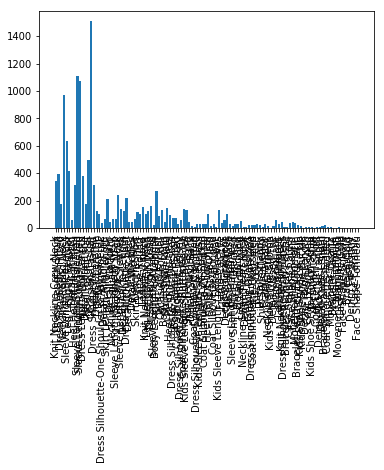

In [26]:
# Show number of products per attribute
print('plot number of products per attribute')
plt.bar(range(len(dict_attribute_nb_products)), list(dict_attribute_nb_products.values()), align='center')
plt.xticks(range(len(dict_attribute_nb_products)), list(dict_attribute_nb_products.keys()))
plt.xticks(rotation=90)
# # for python 2.x:
# plt.bar(range(len(dict_attribute_nb_products)), dict_attribute_nb_products.values(), align='center')  # python 2.x
# plt.xticks(range(len(dict_attribute_nb_products)), dict_attribute_nb_products.keys())  # in python 2.x
plt.show()

In [33]:
# Get max and min number of products per attribute
min_products = sys.maxsize
min_products_attribute = ''
max_products = 0
max_products_attribute = ''
for category, nb_products in dict_attribute_nb_products.items():
    if nb_products < min_products:
        min_products = nb_products
        min_products_attribute = category
    if nb_products > max_products:
        max_products = nb_products
        max_products_cat = category

print('attribute {} has the max number of products, i.e., {}'.format(max_products_attribute, max_products))
print('attribute {} has the min number of products, i.e., {}'.format(min_products_attribute, min_products))
print('mean number of products per attribute: {}'.format(round(np.mean(nb_products_attribute), 2)))
print('standard deviation of number of products per attribute: {}'.format(round(np.std(nb_products_attribute), 2)))


attribute  has the max number of products, i.e., 1512
attribute Case-White Gold has the min number of products, i.e., 1
mean number of products per attribute: 120.13
standard deviation of number of products per attribute: 233.28


In [35]:
# Create a dictionary, key: product id -> value: one-hot encoding list of attributes
list_attribute_value = df_attribute[attribute_col_name].unique()
dict_product_att = dict()

for product_id in list_product_id:
    # one-hot encoding list of attribute value name
    dict_product_att[product_id] = dict()
    for attribute in list_attribute_value:
        dict_product_att[product_id][attribute] = 0
    list_product_attribute = df_product_attribute[df_product_attribute[product_id_col_name] == product_id][attribute_col_name]
    for attribute in list_product_attribute:
        dict_product_att[product_id][attribute] = 1
        
#display(dict_product_att)
for key, value in dict_product_att.items():
    print(key)
    print(value)

11290663
{'Sleeve Length-3/4 Sleeves': 1, 'Knit Neckline-Crew Neck': 0, 'Detail-Stiletto': 0, 'Heel Height-High Heel': 0, 'Leg Length-Regular': 0, 'Neckline-Round Neck': 0, 'Sleeve Length-Shortsleeved': 0, 'Leg Length-Cropped': 0, 'Rise-Mid Rise': 0, 'Occasion-Casual': 0, 'Kids Sleeve Length-Long Sleeves': 0, 'Kids Sleeve Length-Short Sleeves': 0, 'Skirt Length-Mid-Length': 0, 'Frame-Round': 0, 'Lenses-Tinted': 0, 'Detail-Almond toe': 0, 'Heel Height-Flat': 0, 'Kids Sleeve Length-Sleeveless': 0, 'Skirt Length-Long': 0, 'Denim Fit-Slim': 0, 'Sleeve Length-Longsleeved': 0, 'Dress Length-Short': 0, 'Dress Silhouette-Shift': 0, 'Sleeve Length-Sleeveless': 0, 'Sleeve Length-Spaghetti Strap': 0, 'Dress Silhouette-Flared': 0, 'Dress Length-Mid-Length': 0, 'Dress Silhouette-Fitted': 0, 'Neckline-Square Neck': 0, 'Neckline-V Neck': 0, 'Detail-Round toe': 0, 'Dress Silhouette-One Shoulder & Asymmetric': 0, 'Detail-Open Toe': 0, 'Dress Length-Long': 0, 'Detail-Sling Back': 0, 'Skirt Length-Short'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



{'Sleeve Length-3/4 Sleeves': 0, 'Knit Neckline-Crew Neck': 0, 'Detail-Stiletto': 0, 'Heel Height-High Heel': 0, 'Leg Length-Regular': 0, 'Neckline-Round Neck': 0, 'Sleeve Length-Shortsleeved': 0, 'Leg Length-Cropped': 0, 'Rise-Mid Rise': 0, 'Occasion-Casual': 0, 'Kids Sleeve Length-Long Sleeves': 0, 'Kids Sleeve Length-Short Sleeves': 0, 'Skirt Length-Mid-Length': 0, 'Frame-Round': 0, 'Lenses-Tinted': 0, 'Detail-Almond toe': 0, 'Heel Height-Flat': 0, 'Kids Sleeve Length-Sleeveless': 0, 'Skirt Length-Long': 0, 'Denim Fit-Slim': 0, 'Sleeve Length-Longsleeved': 0, 'Dress Length-Short': 0, 'Dress Silhouette-Shift': 0, 'Sleeve Length-Sleeveless': 0, 'Sleeve Length-Spaghetti Strap': 0, 'Dress Silhouette-Flared': 0, 'Dress Length-Mid-Length': 0, 'Dress Silhouette-Fitted': 0, 'Neckline-Square Neck': 0, 'Neckline-V Neck': 0, 'Detail-Round toe': 0, 'Dress Silhouette-One Shoulder & Asymmetric': 0, 'Detail-Open Toe': 0, 'Dress Length-Long': 0, 'Detail-Sling Back': 0, 'Skirt Length-Short': 0, 'Le

{'Sleeve Length-3/4 Sleeves': 0, 'Knit Neckline-Crew Neck': 0, 'Detail-Stiletto': 0, 'Heel Height-High Heel': 0, 'Leg Length-Regular': 0, 'Neckline-Round Neck': 0, 'Sleeve Length-Shortsleeved': 0, 'Leg Length-Cropped': 0, 'Rise-Mid Rise': 0, 'Occasion-Casual': 1, 'Kids Sleeve Length-Long Sleeves': 0, 'Kids Sleeve Length-Short Sleeves': 0, 'Skirt Length-Mid-Length': 0, 'Frame-Round': 0, 'Lenses-Tinted': 0, 'Detail-Almond toe': 0, 'Heel Height-Flat': 0, 'Kids Sleeve Length-Sleeveless': 0, 'Skirt Length-Long': 0, 'Denim Fit-Slim': 0, 'Sleeve Length-Longsleeved': 0, 'Dress Length-Short': 0, 'Dress Silhouette-Shift': 0, 'Sleeve Length-Sleeveless': 0, 'Sleeve Length-Spaghetti Strap': 0, 'Dress Silhouette-Flared': 0, 'Dress Length-Mid-Length': 0, 'Dress Silhouette-Fitted': 0, 'Neckline-Square Neck': 0, 'Neckline-V Neck': 0, 'Detail-Round toe': 0, 'Dress Silhouette-One Shoulder & Asymmetric': 0, 'Detail-Open Toe': 0, 'Dress Length-Long': 0, 'Detail-Sling Back': 0, 'Skirt Length-Short': 0, 'Len

## Step 2: Prepare train and test sets

In [38]:
percentage_train_set = 0.7
shuffle(list_product_id)
list_product_id_train = list_product_id[0:int(percentage_train_set*len(list_product_id))]
list_product_id_test = list_product_id[len(list_product_id_train):]

print('number of samples: {}'.format(len(list_product_id)))
print('number of train samples: {}'.format(len(list_product_id_train)))
print('number of test samples: {}'.format(len(list_product_id_test)))

number of samples: 7362
number of train samples: 5153
number of test samples: 2209


## Step 3: NLP for attribute classification

In [39]:
class_names = list_attribute_value
display(class_names)

array(['Sleeve Length-3/4 Sleeves', 'Knit Neckline-Crew Neck',
       'Detail-Stiletto', 'Heel Height-High Heel', 'Leg Length-Regular',
       'Neckline-Round Neck', 'Sleeve Length-Shortsleeved',
       'Leg Length-Cropped', 'Rise-Mid Rise', 'Occasion-Casual',
       'Kids Sleeve Length-Long Sleeves',
       'Kids Sleeve Length-Short Sleeves', 'Skirt Length-Mid-Length',
       'Frame-Round', 'Lenses-Tinted', 'Detail-Almond toe',
       'Heel Height-Flat', 'Kids Sleeve Length-Sleeveless',
       'Skirt Length-Long', 'Denim Fit-Slim', 'Sleeve Length-Longsleeved',
       'Dress Length-Short', 'Dress Silhouette-Shift',
       'Sleeve Length-Sleeveless', 'Sleeve Length-Spaghetti Strap',
       'Dress Silhouette-Flared', 'Dress Length-Mid-Length',
       'Dress Silhouette-Fitted', 'Neckline-Square Neck',
       'Neckline-V Neck', 'Detail-Round toe',
       'Dress Silhouette-One Shoulder & Asymmetric', 'Detail-Open Toe',
       'Dress Length-Long', 'Detail-Sling Back', 'Skirt Length-Short',
 

In [41]:
train_text = []
train_attribute = dict()

for class_name in class_names:
    train_attribute[class_name] = []

for product_id in list_product_id_train:
    train_text.append(dict_product_des[product_id])
    for class_name in class_names:
        train_attribute[class_name].append(dict_product_att[product_id][class_name])
        
display(train_text)

["Provocative, irreverent and playful, Moschino is the go-to label for those who like their fashion with a sense of humour. Known widely for its iconic phone cases, fragrances and logo T-shirts, Franco Moschino's label has its roots firmly in satire and parody. This pencil skirt from Moschino features a mid rise, side zipped pockets, a mid length and a straight hem. Characterised by a front zip fastening realised in gold-tone hardware, this edgy skirt is both feminine and tough. Nod to the retro mood and style yours with a polka dot crop top. ",
 "Blue  cotton 'Duke' denim shirt from Golden Goose Deluxe Brand featuring a classic collar, a front button fastening, two chest patch pockets, long sleeves, button cuffs and a curved hem. ",
 'Blush pink wool-mohair blend flared slit sleeves coat from Roksanda. ',
 'White cotton grid print T-shirt from Carven. ',
 'Black embellished frame sunglasses  from Miu Miu Eyewear. ',
 'White cotton logo print T-shirt  from STONE ISLAND KIDS featuring a

In [42]:
test_text = []
test_attribute = dict()

for class_name in class_names:
    test_attribute[class_name] = []

for product_id in list_product_id_test:
    test_text.append(dict_product_des[product_id])
    for class_name in class_names:
        test_attribute[class_name].append(dict_product_att[product_id][class_name])
        
display(test_text)

["Grey cotton 'Cult' blouse from A.F.Vandevorst. ",
 'Blue cotton classic polo shirt    from Brunello Cucinelli. ',
 'Blue cotton-wool blend and silk trim detail blazer from Etro. ',
 'Black  leather Rosalia sandals from Vince. ',
 'Black lambskin belted leather skirt  from Iro. ',
 "Matte lavender pink 'Milwood' sunglasses from Garrett Leight featuring photochromic lenses that go dark in sunlight. ",
 'Brown cotton blend sleeveless shirt dress from DSQUARED2 featuring a band collar, a concealed front button placket, front flap pockets, a drawstring waist, a straight hem and a short length. ',
 'Grey wool turtle neck jumper from Stephan Schneider. ',
 "Gold-tone leather 'Cruel' sandals from Giuseppe Zanotti Design featuring an open toe, a thong strap, a metallic sheen, a brand embossed insole, a flat heel and a signature tonal flame design. ",
 'Lavender blue silk sheer short sleeve blouse from Elizabeth And James. ',
 "Silver-tone calf leather fringed metallic sneakers  from Tod's. ",

In [43]:
# -------------
# Remove stop words
def cleanupDoc(s):
    stopset = set(stopwords.words('english'))
    stopset.add('wikipedia')
    tokens = text_to_word_sequence(s, filters="\"!'#$%&()*+,-˚˙./:;‘“<=·>?@[]^_`{|}~\t\n", lower=True, split=" ")
    cleanup = " ".join(filter(lambda word: word not in stopset, tokens))
    return cleanup

train_text = [cleanupDoc(text) for text in train_text]
test_text = [cleanupDoc(text) for text in test_text]

display(train_text)
display(test_text)

['provocative irreverent playful moschino go label like fashion sense humour known widely iconic phone cases fragrances logo shirts franco moschino label roots firmly satire parody pencil skirt moschino features mid rise side zipped pockets mid length straight hem characterised front zip fastening realised gold tone hardware edgy skirt feminine tough nod retro mood style polka dot crop top',
 'blue cotton duke denim shirt golden goose deluxe brand featuring classic collar front button fastening two chest patch pockets long sleeves button cuffs curved hem',
 'blush pink wool mohair blend flared slit sleeves coat roksanda',
 'white cotton grid print shirt carven',
 'black embellished frame sunglasses miu miu eyewear',
 'white cotton logo print shirt stone island kids featuring round neck short sleeves straight hem',
 'white calf leather classic lace sneakers fendi featuring round toe lace front fastening branded insole white rubber sole palladium bag bugs detail tongue',
 'grey virgin wo

['grey cotton cult blouse f vandevorst',
 'blue cotton classic polo shirt brunello cucinelli',
 'blue cotton wool blend silk trim detail blazer etro',
 'black leather rosalia sandals vince',
 'black lambskin belted leather skirt iro',
 'matte lavender pink milwood sunglasses garrett leight featuring photochromic lenses go dark sunlight',
 'brown cotton blend sleeveless shirt dress dsquared2 featuring band collar concealed front button placket front flap pockets drawstring waist straight hem short length',
 'grey wool turtle neck jumper stephan schneider',
 'gold tone leather cruel sandals giuseppe zanotti design featuring open toe thong strap metallic sheen brand embossed insole flat heel signature tonal flame design',
 'lavender blue silk sheer short sleeve blouse elizabeth james',
 'silver tone calf leather fringed metallic sneakers tod',
 'white cotton leather lace trainers reebok',
 'black perforated tank top mm6 maison margiela',
 'green leather lace hi top sneakers fear god',
 'w

In [49]:
# --------------
# Extract features
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    # max_features=50000,
    max_features=10000,
    )
train_word_features = word_vectorizer.fit_transform(train_text)
#print('Word TFIDF 1/2')
test_word_features = word_vectorizer.transform(test_text)
#print('Word TFIDF 2/2')

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    # max_features=50000,
    max_features=10000,
    )
train_char_features = char_vectorizer.fit_transform(train_text)
#print('Char TFIDF 1/2')
test_char_features = char_vectorizer.transform(test_text)
#print('Char TFIDF 2/2')

train_features = hstack([train_char_features, train_word_features])
#print('HStack 1/2')
test_features = hstack([test_char_features, test_word_features])
#print('HStack 2/2')



/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<5153x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1644842 stored elements in COOrdinate format>

In [ ]:
pred_attribute = dict()
dict_roc_auc_scores = dict()
dict_roc_auc_cv_scores = dict()

for class_name in class_names:
    train_target = train_attribute[class_name]

    if len(set(train_target)) > 1:
        classifier = LogisticRegression(solver='sag')
        sfm = SelectFromModel(classifier, threshold=0.2)

        train_sparse_matrix = sfm.fit_transform(train_features, train_target)
        # print(train_features.shape)
        # print(train_sparse_matrix.shape)

        # train_sparse_matrix, valid_sparse_matrix, y_train, y_valid = train_test_split(train_sparse_matrix, train_target,
        #                                                                               test_size=0.05, random_state=42)
        test_sparse_matrix = sfm.transform(test_features)

        if train_sparse_matrix.shape[1] <= 0:
            train_sparse_matrix = train_features
            test_sparse_matrix = test_features
        
        #cv_score = np.mean(cross_val_score(classifier, train_sparse_matrix, train_target, cv=3, scoring='roc_auc'))
        #dict_roc_auc_cv_scores[class_name] = cv_score
        #print('CV roc auc score for class {} is {}'.format(class_name, cv_score))

        classifier.fit(train_sparse_matrix, train_target)

        pred_attribute[class_name] = classifier.predict_proba(test_sparse_matrix)[:, 1]
        #pred_attribute[class_name] = classifier.predict(test_sparse_matrix)

        test_target = test_attribute[class_name]
        if(len(set(test_target)) > 1):
            score = roc_auc_score(test_target, pred_attribute[class_name])
            dict_roc_auc_scores[class_name] = score

        #print('test roc auc score for class {} is {}'.format(class_name, score))
    else:
        print('class {} has only {}'.format(class_name, len(set(train_target))))
        

display(dict_roc_auc_scores)